<a href="https://colab.research.google.com/github/sidh26/Match-Summarizer-Telegram-Bot/blob/master/Model%20Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Read Data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"sidhsatam","key":"5d2a82f91cf79b90f0b970d302cbabef"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d secareanualin/football-events

 95% 20.0M/21.1M [00:00<00:00, 23.6MB/s]
100% 21.1M/21.1M [00:00<00:00, 25.6MB/s]


In [0]:
!unzip /content/football-events.zip

Archive:  /content/football-events.zip
  inflating: dictionary.txt          
  inflating: events.csv              
  inflating: ginf.csv                


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [0]:
df = pd.read_csv('/content/events.csv')
attempts = df[(df.event_type==1)]

In [0]:
df.head()   

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [0]:
attempts = attempts.iloc[:,-6:]

In [0]:
location = {
    1	:'Attacking half',
    2	:'Defensive half',
    3	:'Centre of the box',
    4	:'Left wing',
    5	:'Right wing',
    6	:'Difficult angle and long range',
    7	:'Difficult angle on the left',
    8	:'Difficult angle on the right',
    9	:'Left side of the box',
    10	:'Left side of the six yard box',
    11	:'Right side of the box',
    12	:'Right side of the six yard box',
    13	:'Very close range',
    14	:'Penalty spot',
    15	:'Outside the box',
    16	:'Long range',
    17	:'More than 35 yards',
    18	:'More than 40 yards',
    19	:'Not recorded'
    }


In [0]:
bodypart = {
    1	:'right foot',
    2	:'left foot',
    3	:'head'
    }

In [0]:
assist_method ={
    0	:'None',
    1	:'Pass',
    2	:'Cross',
    3	:'Headed pass',
    4	:'Through ball'
    }

In [0]:
situation = {
    1	:'Open play',
    2	:'Set piece',
    3	:'Corner',
    4	:'Free kick'
    }

In [0]:
attempts.replace({'location':location, 'bodypart':bodypart, 'assist_method': assist_method, 'situation':situation}, inplace=True)

In [0]:
attempts.head()

,is_goal,location,bodypart,assist_method,situation,fast_break
0,0,Left side of the box,left foot,Pass,Open play,0
11,0,Outside the box,right foot,Pass,Open play,0
13,1,Left side of the box,left foot,Pass,Open play,0
14,0,Outside the box,right foot,None,Open play,0
17,0,Outside the box,right foot,None,Open play,0


In [0]:
y = attempts.iloc[:,0] 
X = pd.get_dummies(attempts.iloc[:,1:], columns=['location', 'bodypart','assist_method', 'situation'])

In [0]:
X.head()

,fast_break,location_Centre of the box,location_Difficult angle and long range,location_Difficult angle on the left,location_Difficult angle on the right,location_Left side of the box,location_Left side of the six yard box,location_Long range,location_More than 35 yards,location_More than 40 yards,location_Not recorded,location_Outside the box,location_Penalty spot,location_Right side of the box,location_Right side of the six yard box,location_Very close range,bodypart_head,bodypart_left foot,bodypart_right foot,assist_method_Cross,assist_method_Headed pass,assist_method_None,assist_method_Pass,assist_method_Through ball,situation_Corner,situation_Free kick,situation_Open play,situation_Set piece
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
17,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [0]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=42)

# Creating Ridge Classifier Model + Interpretation

In [0]:
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

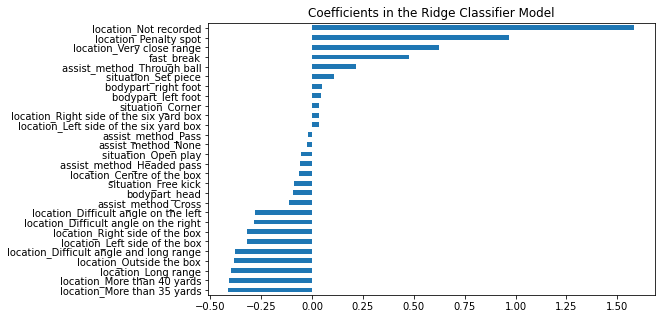

In [0]:
coef = pd.Series(ridge.coef_[0], index = X_train.columns).sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Classifier Model")
plt.show()

In [0]:
ridge.score(X_test, y_test)

0.9096172589866309

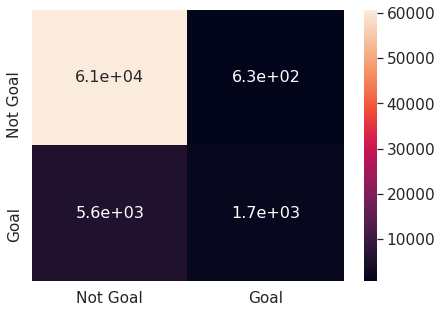

In [0]:
cm = confusion_matrix(y_test, ridge.predict(X_test))
df_cm = pd.DataFrame(cm, index = ['Not Goal', 'Goal'], columns=['Not Goal', 'Goal'])
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

# Match Outcome Prediction

In [0]:
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [0]:
ginf = pd.read_csv('ginf.csv')

In [0]:
ginf.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [0]:
def actual_result_encode(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)

In [0]:
outcome_decode={1: 'Home Wins',
                2: 'Draw',
                3: 'Away Wins'
                }

In [0]:
result = []
for i in range(1, ginf.shape[0]+1):
    result.append(actual_result_encode(ginf[i-1:i]["fthg"].item(), ginf[i-1:i]["ftag"].item()))
y = ginf[['id_odsp']]
y['outcome'] = result
y.set_index("id_odsp", inplace=True)

X1 = ginf.iloc[:, [0, 9, 10, 11, 12, 13]]
X1.set_index("id_odsp", inplace=True)
X1["diff_h_d"] = abs(X1["odd_h"] - X1["odd_d"])
X1["diff_d_a"] = abs(X1["odd_d"] - X1["odd_a"])
X1["diff_h_a"] = abs(X1["odd_h"] - X1["odd_a"])
X1 = X1.drop(["fthg", "ftag"], axis=1)
X1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,odd_h,odd_d,odd_a,diff_h_d,diff_d_a,diff_h_a
id_odsp,,,,,,
UFot0hit/,1.56,4.41,7.42,2.85,3.01,5.86
Aw5DflLH/,2.36,3.60,3.40,1.24,0.20,1.04
bkjpaC6n/,1.83,4.20,4.80,2.37,0.60,2.97
CzPV312a/,1.55,4.50,9.40,2.95,4.90,7.85
GUOdmtII/,2.50,3.40,3.45,0.90,0.05,0.95


In [0]:
X_train, X_test, y_train, y_test = tts(X1, y, test_size=0.3, random_state=42)

In [0]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("Decision Tree Classifier Accuracy: " + str(accuracy_score(y_test, dt.predict(X_test))))
cm = confusion_matrix(y_test, dt.predict(X_test))
cm = pd.DataFrame(cm)
cm.columns = ["Predicted Home Win","Predicted Draw","Predicted Away Win"]
cm.index = ["Actual Home Win","Actual Draw","Actual Away Win"]
cm

Decision Tree Classifier Accuracy: 0.979513987001978


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3228,4,1
Actual Draw,68,1758,0
Actual Away Win,44,28,1947


In [0]:
y_pred = dt.predict(X1)
y_pred = pd.DataFrame(y_pred, index=X1.index, columns=['Predicted Outcome'])
y_pred.replace(outcome_decode, inplace=True)
y_pred

In [0]:
y_pred.to_csv('/content/outcome_predictions.csv')

# Summarization

## Create Extractive Summary 
Through extractive methods we generate summaries to use as ground truth for abstractive methods

In [0]:
commentary = df.groupby(['id_odsp'])['text'].apply(' '.join).reset_index()

In [0]:
commentary.head()

,id_odsp,text
0,004f4ING/,Bafetimbi Gomis (Swansea City) wins a free kic...
1,00LMl81F/,"Offside, Milan. Kevin-Prince Boateng tries a t..."
2,00OX4xFp/,Attempt missed. Bernardo Silva (Monaco) header...
3,00QH2XdM/,"Corner, Reims. Conceded by Youssouf Sabaly. F..."
4,00QL4t1L/,Foul by Adrian Ramos (Borussia Dortmund). Roge...


In [0]:
!pip install bert-extractive-summarizer

In [0]:
!pip install spacy==2.1.3
!pip install transformers==2.2.2
!pip install neuralcoref

In [0]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 95.4MB 1.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126236 sha256=40b71ab33c2929f7d39493883a906f61288c1cc40a061dc52ac8cb221818fcd8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9q963mka/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
from summarizer import Summarizer

In [0]:
model = Summarizer()
t=''
for index, row in commentary.iterrows():
    print(index)
    result = model(row['text'], min_length=60)
    full = ''.join(result)
    t+=full+'\n'

In [0]:
with open('/content/extractive.txt', 'w+') as f:
    f.write(t)

Since it  was taking too long to run, we decided to run it on GCP(10 hrs)

## Create Abstractive Summary

In [0]:
!pip install gensim
!pip install wget

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk.tokenize import word_tokenize
import re
import collections
import pickle
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

In [0]:
#default path for the folder inside google drive
default_path = "/content/drive/My Drive/"

In [0]:
#path for training text (commentary)
train_article_path = "/content/comm.txt"

In [0]:
#path for training text output (summary)
train_title_path = "/content/extractive2.txt"

In [0]:
#path for validation text (commentary)
valid_article_path = "/content/comm.txt"

In [0]:
#path for validation text output (summary)
valid_title_path = "/content/extractive2.txt"

In [0]:
def clean_str(sentence):
    sentence = re.sub(r'\n', '', sentence)
    sentence = re.sub(r'\t', '', sentence)
    sentence = re.sub(r'\r', '', sentence)
    sentence = re.sub(r'[^A-Za-z0-9\säöüÄÖÜß]', ' ', sentence)
    return sentence

In [0]:
def get_text_list(data_path, toy):
    with open (data_path, "r", encoding="utf-8") as f:
        if not toy:
            return [clean_str(x.strip()) for x in f.readlines()][:200000]
        else:
            return [clean_str(x.strip()) for x in f.readlines()][:50]

In [0]:
def build_dict(step, toy=False):
    if step == "train":
        train_article_list = get_text_list(train_article_path, toy)
        train_title_list = get_text_list(train_title_path, toy)

        words = list()
        for sentence in train_article_list + train_title_list:
            for word in word_tokenize(sentence):
                words.append(word)

        word_counter = collections.Counter(words).most_common()
        word_dict = dict()
        word_dict["<padding>"] = 0
        word_dict["<unk>"] = 1
        word_dict["<s>"] = 2
        word_dict["</s>"] = 3
        for word, _ in word_counter:
            word_dict[word] = len(word_dict)

        with open(default_path + "word_dict.pickle", "wb") as f:
            pickle.dump(word_dict, f)

    elif step == "valid":
        with open(default_path + "word_dict.pickle", "rb") as f:
            word_dict = pickle.load(f)

    reversed_dict = dict(zip(word_dict.values(), word_dict.keys()))

    article_max_len = 50
    summary_max_len = 15

    return word_dict, reversed_dict, article_max_len, summary_max_len

In [0]:
def build_dataset(step, word_dict, article_max_len, summary_max_len, toy=False):
    if step == "train":
        article_list = get_text_list(train_article_path, toy)
        title_list = get_text_list(train_title_path, toy)
    elif step == "valid":
        article_list = get_text_list(valid_article_path, toy)
    else:
        raise NotImplementedError

    x = [word_tokenize(d) for d in article_list]
    x = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in x]
    x = [d[:article_max_len] for d in x]
    x = [d + (article_max_len - len(d)) * [word_dict["<padding>"]] for d in x]
    
    if step == "valid":
        return x
    else:        
        y = [word_tokenize(d) for d in title_list]
        y = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in y]
        y = [d[:(summary_max_len - 1)] for d in y]
        return x, y

In [0]:
def get_init_embedding(reversed_dict, embedding_size):
    print("Loading Glove vectors...")
    
    with open(default_path + "glove/model_glove_300.pkl", 'rb') as handle:
        word_vectors = pickle.load(handle)
        
    word_vec_list = list()
    for _, word in sorted(reversed_dict.items()):
        try:
            word_vec = word_vectors.word_vec(word)
        except KeyError:
            word_vec = np.zeros([embedding_size], dtype=np.float32)

        word_vec_list.append(word_vec)

    # Assign random vector to <s>, </s> token
    word_vec_list[2] = np.random.normal(0, 1, embedding_size)
    word_vec_list[3] = np.random.normal(0, 1, embedding_size)

    return np.array(word_vec_list)

In [0]:
def batch_iter(inputs, outputs, batch_size, num_epochs):
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    num_batches_per_epoch = (len(inputs) - 1) // batch_size + 1
    for epoch in range(num_epochs):
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, len(inputs))
            yield inputs[start_index:end_index], outputs[start_index:end_index]

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.contrib import rnn


class Model(object):
    def __init__(self, reversed_dict, article_max_len, summary_max_len, args, forward_only=False):
        self.vocabulary_size = len(reversed_dict)
        self.embedding_size = args.embedding_size
        self.num_hidden = args.num_hidden
        self.num_layers = args.num_layers
        self.learning_rate = args.learning_rate
        self.beam_width = args.beam_width
        if not forward_only:
            self.keep_prob = args.keep_prob
        else:
            self.keep_prob = 1.0
        self.cell = tf.nn.rnn_cell.BasicLSTMCell
        with tf.variable_scope("decoder/projection"):
            self.projection_layer = tf.layers.Dense(self.vocabulary_size, use_bias=False)

        self.batch_size = tf.placeholder(tf.int32, (), name="batch_size")
        self.X = tf.placeholder(tf.int32, [None, article_max_len])
        self.X_len = tf.placeholder(tf.int32, [None])
        self.decoder_input = tf.placeholder(tf.int32, [None, summary_max_len])
        self.decoder_len = tf.placeholder(tf.int32, [None])
        self.decoder_target = tf.placeholder(tf.int32, [None, summary_max_len])
        self.global_step = tf.Variable(0, trainable=False)

        with tf.name_scope("embedding"):
            if not forward_only and args.glove:
                init_embeddings = tf.constant(get_init_embedding(reversed_dict, self.embedding_size), dtype=tf.float32)
            else:
                init_embeddings = tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0)
            self.embeddings = tf.get_variable("embeddings", initializer=init_embeddings)
            self.encoder_emb_inp = tf.transpose(tf.nn.embedding_lookup(self.embeddings, self.X), perm=[1, 0, 2])
            self.decoder_emb_inp = tf.transpose(tf.nn.embedding_lookup(self.embeddings, self.decoder_input), perm=[1, 0, 2])

        with tf.name_scope("encoder"):
            fw_cells = [self.cell(self.num_hidden) for _ in range(self.num_layers)]
            bw_cells = [self.cell(self.num_hidden) for _ in range(self.num_layers)]
            fw_cells = [rnn.DropoutWrapper(cell) for cell in fw_cells]
            bw_cells = [rnn.DropoutWrapper(cell) for cell in bw_cells]

            encoder_outputs, encoder_state_fw, encoder_state_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
                fw_cells, bw_cells, self.encoder_emb_inp,
                sequence_length=self.X_len, time_major=True, dtype=tf.float32)
            self.encoder_output = tf.concat(encoder_outputs, 2)
            encoder_state_c = tf.concat((encoder_state_fw[0].c, encoder_state_bw[0].c), 1)
            encoder_state_h = tf.concat((encoder_state_fw[0].h, encoder_state_bw[0].h), 1)
            self.encoder_state = rnn.LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)

        with tf.name_scope("decoder"), tf.variable_scope("decoder") as decoder_scope:
            decoder_cell = self.cell(self.num_hidden * 2)

            if not forward_only:
                attention_states = tf.transpose(self.encoder_output, [1, 0, 2])
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    self.num_hidden * 2, attention_states, memory_sequence_length=self.X_len, normalize=True)
                decoder_cell = tf.contrib.seq2seq.AttentionWrapper(decoder_cell, attention_mechanism,
                                                                   attention_layer_size=self.num_hidden * 2)
                initial_state = decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size)
                initial_state = initial_state.clone(cell_state=self.encoder_state)
                helper = tf.contrib.seq2seq.TrainingHelper(self.decoder_emb_inp, self.decoder_len, time_major=True)
                decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, initial_state)
                outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=True, scope=decoder_scope)
                self.decoder_output = outputs.rnn_output
                self.logits = tf.transpose(
                    self.projection_layer(self.decoder_output), perm=[1, 0, 2])
                self.logits_reshape = tf.concat(
                    [self.logits, tf.zeros([self.batch_size, summary_max_len - tf.shape(self.logits)[1], self.vocabulary_size])], axis=1)
            else:
                tiled_encoder_output = tf.contrib.seq2seq.tile_batch(
                    tf.transpose(self.encoder_output, perm=[1, 0, 2]), multiplier=self.beam_width)
                tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(self.encoder_state, multiplier=self.beam_width)
                tiled_seq_len = tf.contrib.seq2seq.tile_batch(self.X_len, multiplier=self.beam_width)
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    self.num_hidden * 2, tiled_encoder_output, memory_sequence_length=tiled_seq_len, normalize=True)
                decoder_cell = tf.contrib.seq2seq.AttentionWrapper(decoder_cell, attention_mechanism,
                                                                   attention_layer_size=self.num_hidden * 2)
                initial_state = decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size * self.beam_width)
                initial_state = initial_state.clone(cell_state=tiled_encoder_final_state)
                decoder = tf.contrib.seq2seq.BeamSearchDecoder(
                    cell=decoder_cell,
                    embedding=self.embeddings,
                    start_tokens=tf.fill([self.batch_size], tf.constant(2)),
                    end_token=tf.constant(3),
                    initial_state=initial_state,
                    beam_width=self.beam_width,
                    output_layer=self.projection_layer
                )
                outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
                    decoder, output_time_major=True, maximum_iterations=summary_max_len, scope=decoder_scope)
                self.prediction = tf.transpose(outputs.predicted_ids, perm=[1, 2, 0])

        with tf.name_scope("loss"):
            if not forward_only:
                crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits_reshape, labels=self.decoder_target)
                weights = tf.sequence_mask(self.decoder_len, summary_max_len, dtype=tf.float32)
                self.loss = tf.reduce_sum(crossent * weights / tf.to_float(self.batch_size))

                params = tf.trainable_variables()
                gradients = tf.gradients(self.loss, params)
                clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
                optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.update = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=self.global_step)

TensorFlow 1.x selected.


In [0]:
import time
start = time.perf_counter()
import tensorflow as tf
import argparse
import pickle
import os

class args:
    pass
  
args.num_hidden=150
args.num_layers=2
args.beam_width=10
args.glove="store_true"
args.embedding_size=300

args.learning_rate=1e-3
args.batch_size=64
args.num_epochs=10
args.keep_prob = 0.8

args.toy=False #"store_true"

args.with_model="store_true"


if not os.path.exists(default_path + "saved_model"):
    os.mkdir(default_path + "saved_model")
else:
    old_model_checkpoint_path = open(default_path + 'saved_model/checkpoint', 'r')
    old_model_checkpoint_path = "".join([default_path + "saved_model/",old_model_checkpoint_path.read().splitlines()[0].split('"')[1] ])


print("Building dictionary...")
word_dict, reversed_dict, article_max_len, summary_max_len = build_dict("train", args.toy)
print("Loading training dataset...")
train_x, train_y = build_dataset("train", word_dict, article_max_len, summary_max_len, args.toy)

tf.reset_default_graph()

with tf.Session() as sess:
    model = Model(reversed_dict, article_max_len, summary_max_len, args)
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    # if 'old_model_checkpoint_path' in globals():
    #     print("Continuing from previous trained model:" , old_model_checkpoint_path , "...")
    #     saver.restore(sess, old_model_checkpoint_path )

    batches = batch_iter(train_x, train_y, args.batch_size, args.num_epochs)
    num_batches_per_epoch = (len(train_x) - 1) // args.batch_size + 1

    print("\nIteration starts.")
    print("Number of batches per epoch :", num_batches_per_epoch)
    for batch_x, batch_y in batches:
        batch_x_len = list(map(lambda x: len([y for y in x if y != 0]), batch_x))
        batch_decoder_input = list(map(lambda x: [word_dict["<s>"]] + list(x), batch_y))
        batch_decoder_len = list(map(lambda x: len([y for y in x if y != 0]), batch_decoder_input))
        batch_decoder_output = list(map(lambda x: list(x) + [word_dict["</s>"]], batch_y))

        batch_decoder_input = list(
            map(lambda d: d + (summary_max_len - len(d)) * [word_dict["<padding>"]], batch_decoder_input))
        batch_decoder_output = list(
            map(lambda d: d + (summary_max_len - len(d)) * [word_dict["<padding>"]], batch_decoder_output))

        train_feed_dict = {
            model.batch_size: len(batch_x),
            model.X: batch_x,
            model.X_len: batch_x_len,
            model.decoder_input: batch_decoder_input,
            model.decoder_len: batch_decoder_len,
            model.decoder_target: batch_decoder_output
        }

        _, step, loss = sess.run([model.update, model.global_step, model.loss], feed_dict=train_feed_dict)

        if step % 1000 == 0:
            print("step {0}: loss = {1}".format(step, loss))

        if step % num_batches_per_epoch == 0:
            hours, rem = divmod(time.perf_counter() - start, 3600)
            minutes, seconds = divmod(rem, 60)
            saver.save(sess, default_path + "saved_model/model.ckpt", global_step=step)
            print(" Epoch {0}: Model is saved.".format(step // num_batches_per_epoch),
            "Elapsed: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds) , "\n")

Building dictionary...
Loading training dataset...
Loading Glove vectors...


FileNotFoundError: ignored

In [0]:
# !rm -r "/content/drive/My Drive/saved_model"

In [0]:
import tensorflow as tf
import pickle


tf.reset_default_graph()

class args:
    pass
  
args.num_hidden=150
args.num_layers=2
args.beam_width=10
args.glove="store_true"
args.embedding_size=300

args.learning_rate=1e-3
args.batch_size=64
args.num_epochs=10
args.keep_prob = 0.8

args.toy=False

args.with_model="store_true"



print("Loading dictionary...")
word_dict, reversed_dict, article_max_len, summary_max_len = build_dict("valid", args.toy)
print("Loading validation dataset...")
valid_x = build_dataset("valid", word_dict, article_max_len, summary_max_len, args.toy)
valid_x_len = [len([y for y in x if y != 0]) for x in valid_x]
print("Loading article and reference...")
article = get_text_list(valid_article_path, args.toy)
reference = get_text_list(valid_title_path, args.toy)

with tf.Session() as sess:
    print("Loading saved model...")
    model = Model(reversed_dict, article_max_len, summary_max_len, args, forward_only=True)
    saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(default_path + "saved_model/")
    saver.restore(sess, ckpt.model_checkpoint_path)

    batches = batch_iter(valid_x, [0] * len(valid_x), args.batch_size, 1)

    print("Writing summaries to 'result.txt'...")
    for batch_x, _ in batches:
        batch_x_len = [len([y for y in x if y != 0]) for x in batch_x]

        valid_feed_dict = {
            model.batch_size: len(batch_x),
            model.X: batch_x,
            model.X_len: batch_x_len,
        }

        prediction = sess.run(model.prediction, feed_dict=valid_feed_dict)
        prediction_output = [[reversed_dict[y] for y in x] for x in prediction[:, 0, :]]
        summary_array = []
        with open(default_path + "result.txt", "a") as f:
            for line in prediction_output:
                summary = list()
                for word in line:
                    if word == "</s>":
                        break
                    if word not in summary:
                        summary.append(word)
                summary_array.append(" ".join(summary))
                print(" ".join(summary), file=f)

    print('Summaries have been generated')

Loading dictionary...
Loading validation dataset...
Loading article and reference...
Loading saved model...
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/saved_model/model.ckpt-790
Writing summaries to 'result.txt'...
Summaries have been generated


In [0]:
!pip install sumeval
!python -m spacy download en

In [0]:
summary_array

In [0]:
len(summary_array)

17

In [0]:
from sumeval.metrics.rouge import RougeCalculator
# from sumeval.metrics.bleu import BLEUCalculator

def eval_rouges(refrence_summary,model_summary):
    #refrence_summary = "tokyo shares close up #.## percent"
    #model_summary = "tokyo stocks close up # percent to fresh record high"

    rouge = RougeCalculator(stopwords=True, lang="en")

    rouge_1 = rouge.rouge_n(
                summary=model_summary,
                references=refrence_summary,
                n=1)

    rouge_2 = rouge.rouge_n(
                summary=model_summary,
                references=[refrence_summary],
                n=2)
    
    rouge_l = rouge.rouge_l(
                summary=model_summary,
                references=[refrence_summary])
    
    # You need spaCy to calculate ROUGE-BE
    
    rouge_be = rouge.rouge_be(
                summary=model_summary,
                references=[refrence_summary])

    # bleu = BLEUCalculator()
    # bleu_score = bleu.bleu( summary=model_summary,
    #                     references=[refrence_summary])

    #print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}, ROUGE-BE: {}".format(
    #    rouge_1, rouge_2, rouge_l, rouge_be
    #).replace(", ", "\n"))
    bleu_score=0
    return rouge_1, rouge_2,rouge_l,rouge_be,bleu_score
  
#rouge_1, rouge_2,rouge_l,rouge_be = eval_rouges( "tokyo shares close up #.## percent",
#                                                "tokyo stocks close up # percent to fresh record high")
#
#print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}, ROUGE-BE: {}".format(
#        rouge_1, rouge_2, rouge_l, rouge_be
#    ).replace(", ", "\n"))

In [0]:
#https://pymotw.com/2/xml/etree/ElementTree/create.html

bleu_arr = []
rouge_1_arr  = []
rouge_2_arr  = []
rouge_L_arr  = []
rouge_be_arr = []

from xml.etree import ElementTree
from xml.dom import minidom
from functools import reduce

def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")
  
from xml.etree.ElementTree import Element, SubElement, Comment

top = Element('ZakSum')

comment = Comment('Generated by Amr Zaki')
top.append(comment)

i=0
for summ in summary_array:
  example = SubElement(top, 'example')
  article_element   = SubElement(example, 'article')
  article_element.text = article[i]
  
  reference_element = SubElement(example, 'reference')
  reference_element.text = reference[i]
  
  summary_element   = SubElement(example, 'summary')
  summary_element.text = summ

  rouge_1, rouge_2,rouge_L,rouge_be,bleu_score = eval_rouges(reference[i],summ )
  
  eval_element = SubElement(example, 'eval')
  bleu_score_element = SubElement(eval_element,'BLEU', {'score':str(bleu_score)})
  ROUGE_1_element  = SubElement(eval_element, 'ROUGE_1' , {'score':str(rouge_1)})
  ROUGE_2_element  = SubElement(eval_element, 'ROUGE_2' , {'score':str(rouge_2)})
  ROUGE_L_element  = SubElement(eval_element, 'ROUGE_l' , {'score':str(rouge_L)})
  ROUGE_be_element  = SubElement(eval_element,'ROUGE_be', {'score':str(rouge_be)})
  
  bleu_arr.append(bleu_score) 
  rouge_1_arr.append(rouge_1) 
  rouge_2_arr.append(rouge_2) 
  rouge_L_arr.append(rouge_L) 
  rouge_be_arr.append(rouge_be) 

  i+=1

top.set('bleu', str(reduce(lambda x, y: x + y,  bleu_arr) / len(bleu_arr)))
top.set('rouge_1', str(reduce(lambda x, y: x + y,  rouge_1_arr) / len(rouge_1_arr)))
top.set('rouge_2', str(reduce(lambda x, y: x + y,  rouge_2_arr) / len(rouge_2_arr)))
top.set('rouge_L', str(reduce(lambda x, y: x + y,  rouge_L_arr) / len(rouge_L_arr)))
top.set('rouge_be', str(reduce(lambda x, y: x + y, rouge_be_arr) / len(rouge_be_arr)))

with open(default_path + "result_valid_29_10_2018_5_28pm.xml", "w+") as f:
  print(prettify(top), file=f)

a.injury=(nsubj)=>leaves
<BasicElement: injury-[nsubj]->leave>
a.hopes=(dobj)=>leaves
<BasicElement: hopes-[dobj]->leave>
a.leaders=(nsubj)=>lash
<BasicElement: leaders-[nsubj]->lash>
b.tough=(amod)=>law
a.sales=(nsubj)=>fall
<BasicElement: sales-[nsubj]->fall>
a.percent=(npadvmod)=>fall
<BasicElement: percent-[npadvmod]->fall>
a.thousands=(nsubj)=>celebrate
<BasicElement: thousands-[nsubj]->celebrate>
b.attend=(advcl)=>rice
a.inauguration=(dobj)=>attend
<BasicElement: inauguration-[dobj]->attend>
b.top=(amod)=>lobbyist
b.republican=(amod)=>lobbyist
a.lobbyist=(nsubj)=>pleads
<BasicElement: lobbyist-[nsubj]->plead>
a.workers=(dobj)=>hits
<BasicElement: workers-[dobj]->hit>
b.portuguese=(amod)=>workers
a.strike=(nsubj)=>ground
<BasicElement: strike-[nsubj]->ground>
a.flights=(dobj)=>ground
<BasicElement: flights-[dobj]->ground>
b.scolari=(amod)=>signs
a.stars=(nsubj)=>get
<BasicElement: stars-[nsubj]->get>
b.new=(amod)=>sequel
a.sequel=(dobj)=>get
<BasicElement: sequel-[dobj]->get>
a.su

# Done!